## Technical Analysis

In [2]:
#Installing the technical analysis library

#! pip install --upgrade ta

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
import re
import warnings
import itertools
import collections
import ta


warnings.filterwarnings('ignore')

In [4]:
from matplotlib.colors import LinearSegmentedColormap
from functools import reduce
from math import ceil
from datetime import timedelta, datetime
from ta import add_all_ta_features
from ta.utils import dropna

In [5]:
COLORS = ['#2ec4b6', '#1e9fb4', '#0f7ab2', '#285892', '#49306b', '#7a3161', '#a13258', '#c63351', '#ea3449']

CAT_COLORS = ['#2EC4B6', '#0E79B2', '#49306B', '#9A325A', '#EA3449']
CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = ['#0e79b2', '#4b9ac3', '#84b8d4', '#bcd6e4', '#f4f4f4', '#c6c0d0', '#9b8eac', '#715e8b', '#49306b']

DIV_COL_HALF = ['#f4f4f4', '#bed3da', '#8ab2bf', '#5592a5', '#20718b']

UMP_COLORS = ['#22446D', '#FC9E4F', '#AB2346' ,'#6ABB5D']

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)
DIVHALF_PALETTE = sns.color_palette(DIV_COL_HALF)
CAT_PALETTE = sns.color_palette(CAT_COLORS)
UMP_PALETTE = sns.color_palette(UMP_COLORS)


DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)
DIV_H_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COL_HALF)
CAT_CMAP = LinearSegmentedColormap.from_list("cat_colors", CAT_COLORS)
UMP_CMAP = LinearSegmentedColormap.from_list("ump_colors", UMP_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = True
RANDOM_STATE = 9

IMG_PATH = 'imgs/'
DATA_IN_PATH = '../../source/data/'
DATA_OUT_PATH = '../data_out/'

### Load data

In [6]:
df_close = pd.read_csv(DATA_IN_PATH + "close.csv")
df_close.head(3)

,Date,ADA-USD,ATOM-USD,AVAX-USD,AXS-USD,BTC-USD,ETH-USD,LINK-USD,LUNA1-USD,MATIC-USD,SOL-USD
0,2017-04-26,NaN,NaN,NaN,NaN,1281.079956,NaN,NaN,NaN,NaN,NaN
1,2017-04-27,NaN,NaN,NaN,NaN,1317.729980,NaN,NaN,NaN,NaN,NaN
2,2017-04-28,NaN,NaN,NaN,NaN,1316.479980,NaN,NaN,NaN,NaN,NaN


In [7]:
df_high = pd.read_csv(DATA_IN_PATH + "high.csv")
df_high.head(3)

,Date,ADA-USD,ATOM-USD,AVAX-USD,AXS-USD,BTC-USD,ETH-USD,LINK-USD,LUNA1-USD,MATIC-USD,SOL-USD
0,2017-04-26,NaN,NaN,NaN,NaN,1294.829956,NaN,NaN,NaN,NaN,NaN
1,2017-04-27,NaN,NaN,NaN,NaN,1319.699951,NaN,NaN,NaN,NaN,NaN
2,2017-04-28,NaN,NaN,NaN,NaN,1331.280029,NaN,NaN,NaN,NaN,NaN


In [8]:
df_low = pd.read_csv(DATA_IN_PATH + "low.csv")
df_low.head(3)

,Date,ADA-USD,ATOM-USD,AVAX-USD,AXS-USD,BTC-USD,ETH-USD,LINK-USD,LUNA1-USD,MATIC-USD,SOL-USD
0,2017-04-26,NaN,NaN,NaN,NaN,1265.930054,NaN,NaN,NaN,NaN,NaN
1,2017-04-27,NaN,NaN,NaN,NaN,1281.300049,NaN,NaN,NaN,NaN,NaN
2,2017-04-28,NaN,NaN,NaN,NaN,1292.369995,NaN,NaN,NaN,NaN,NaN


In [9]:
df_open = pd.read_csv(DATA_IN_PATH + "open.csv")
df_open.head(3)

,Date,ADA-USD,ATOM-USD,AVAX-USD,AXS-USD,BTC-USD,ETH-USD,LINK-USD,LUNA1-USD,MATIC-USD,SOL-USD
0,2017-04-26,NaN,NaN,NaN,NaN,1265.989990,NaN,NaN,NaN,NaN,NaN
1,2017-04-27,NaN,NaN,NaN,NaN,1281.880005,NaN,NaN,NaN,NaN,NaN
2,2017-04-28,NaN,NaN,NaN,NaN,1317.739990,NaN,NaN,NaN,NaN,NaN


In [10]:
df_vol = pd.read_csv(DATA_IN_PATH + "volume.csv")
df_vol.head(3)

,Date,ADA-USD,ATOM-USD,AVAX-USD,AXS-USD,BTC-USD,ETH-USD,LINK-USD,LUNA1-USD,MATIC-USD,SOL-USD
0,2017-04-26,NaN,NaN,NaN,NaN,329631008,NaN,NaN,NaN,NaN,NaN
1,2017-04-27,NaN,NaN,NaN,NaN,449196992,NaN,NaN,NaN,NaN,NaN
2,2017-04-28,NaN,NaN,NaN,NaN,527488992,NaN,NaN,NaN,NaN,NaN


In [11]:
df_list = [df_close,df_close,df_high,df_low]

In [12]:
df_ada = df_close[['Date','ADA-USD']].rename(columns={'ADA-USD':'close'})\
        .merge(df_high[['Date','ADA-USD']].rename(columns={'ADA-USD':'high'}), left_on='Date', right_on='Date')\
        .merge(df_low[['Date','ADA-USD']].rename(columns={'ADA-USD':'low'}), left_on='Date', right_on='Date')\
        .merge(df_open[['Date','ADA-USD']].rename(columns={'ADA-USD':'open'}), left_on='Date', right_on='Date')\
        .merge(df_vol[['Date','ADA-USD']].rename(columns={'ADA-USD':'volume'}), left_on='Date', right_on='Date')

#df_ada = pd.DataFrame(columns=df_cols)
df_ada

,Date,close,high,low,open,volume
0,2017-04-26,NaN,NaN,NaN,NaN,NaN
1,2017-04-27,NaN,NaN,NaN,NaN,NaN
2,2017-04-28,NaN,NaN,NaN,NaN,NaN
3,2017-04-29,NaN,NaN,NaN,NaN,NaN
4,2017-04-30,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1821,2022-04-21,0.910474,0.969453,0.896912,0.937272,8.711113e+08
1822,2022-04-22,0.907154,0.923741,0.893973,0.910335,7.257889e+08
1823,2022-04-23,0.888503,0.910614,0.884660,0.907185,4.479977e+08
1824,2022-04-24,0.886350,0.897855,0.881857,0.888279,4.876295e+08


In [13]:
def assemble_coin_df(coin_i):
    df_data = df_close[['Date',coin_i]].rename(columns={coin_i:'close'})\
            .merge(df_high[['Date',coin_i]].rename(columns={coin_i:'high'}), left_on='Date', right_on='Date')\
            .merge(df_low[['Date',coin_i]].rename(columns={coin_i:'low'}), left_on='Date', right_on='Date')\
            .merge(df_open[['Date',coin_i]].rename(columns={coin_i:'open'}), left_on='Date', right_on='Date')\
            .merge(df_vol[['Date',coin_i]].rename(columns={coin_i:'volume'}), left_on='Date', right_on='Date')
    return df_data


df_ada   = assemble_coin_df('ADA-USD')
df_atom  = assemble_coin_df('ATOM-USD')
df_avax  = assemble_coin_df('AVAX-USD')
df_axs   = assemble_coin_df('AXS-USD')
df_btc   = assemble_coin_df('BTC-USD')
df_eth   = assemble_coin_df('ETH-USD')
df_link  = assemble_coin_df('LINK-USD')
df_luna1 = assemble_coin_df('LUNA1-USD')
df_matic = assemble_coin_df('MATIC-USD')
df_sol   = assemble_coin_df('SOL-USD')

df_coins_list = [df_ada, df_atom, df_avax, df_axs, df_btc, df_eth, df_link, df_luna1, df_matic, df_sol]
df_coins_suff = ['ada', 'atom', 'avax', 'axs', 'btc', 'eth', 'link', 'luna1', 'matic', 'sol']

### For ADA

In [14]:
# Load data
df_ada = df_ada[~(df_ada['Date'] > '2020-12-31')]

# Clean nan values
df_ada = ta.utils.dropna(df_ada)

print(df_ada.columns)

# Add all ta features filling nans values
df = ta.add_all_ta_features(
    df_ada, "open", "high", "low", "close", "volume", fillna=True
)

print(df_ada.columns)
print(len(df_ada.columns))

Index(['Date', 'close', 'high', 'low', 'open', 'volume'], dtype='object')
Index(['Date', 'close', 'high', 'low', 'open', 'volume', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em',
       'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbp', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
       'volatility_kcp', 'volatility_kchi', 'volatility_kcli',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
   

In [15]:
df_ta_ada=df_ada[['Date','volume_obv','momentum_rsi','trend_macd','volatility_atr']].copy()

In [16]:
df_ta_ada.columns = ['Date', 'ada_volume_obv','ada_momentum_rsi','ada_trend_macd','ada_volatility_atr']

In [17]:
# Creating visualizations
mpl.style.use('seaborn')

In [18]:
df_ada.shape

(1149, 92)

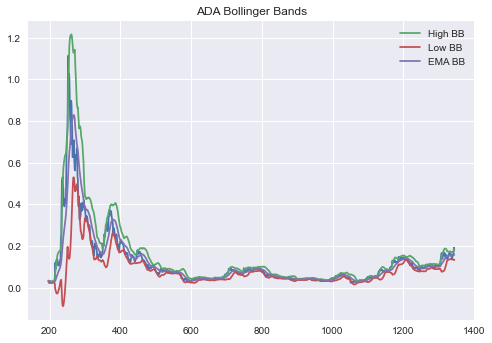

In [19]:
#Bollinger Bands

plt.plot(df_ada[0:1148].close)
plt.plot(df_ada[0:1148].volatility_bbh, label='High BB')
plt.plot(df_ada[0:1148].volatility_bbl, label='Low BB')
plt.plot(df_ada[0:1148].volatility_bbm, label='EMA BB')
plt.title('ADA Bollinger Bands')
plt.legend()
plt.show()

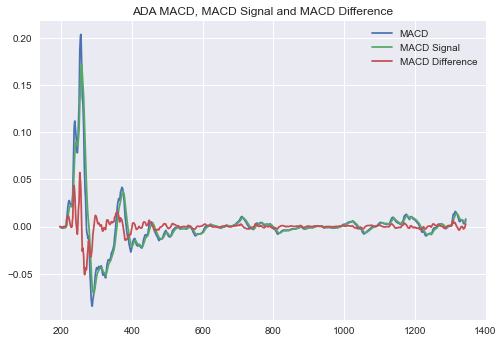

In [20]:
# MACD

plt.plot(df_ada[0:1148].trend_macd, label='MACD')
plt.plot(df_ada[0:1148].trend_macd_signal, label='MACD Signal')
plt.plot(df_ada[0:1148].trend_macd_diff, label='MACD Difference')
plt.title('ADA MACD, MACD Signal and MACD Difference')
plt.legend()
plt.show()

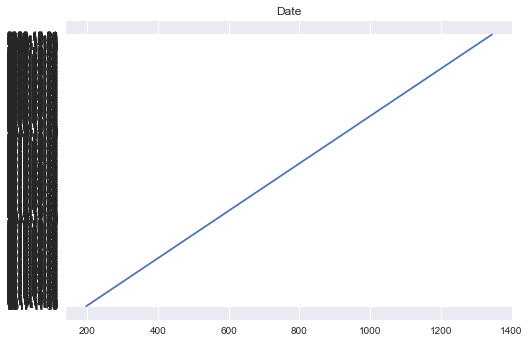

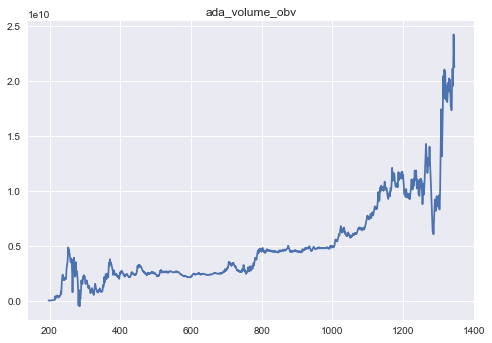

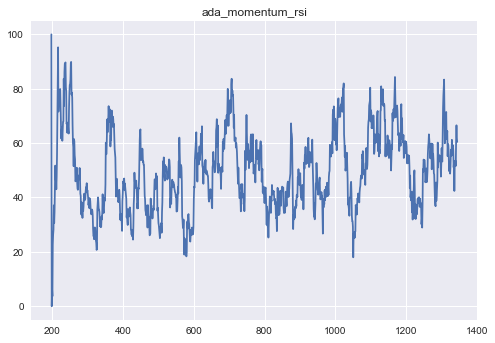

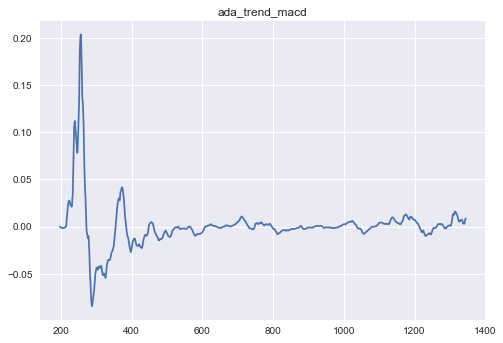

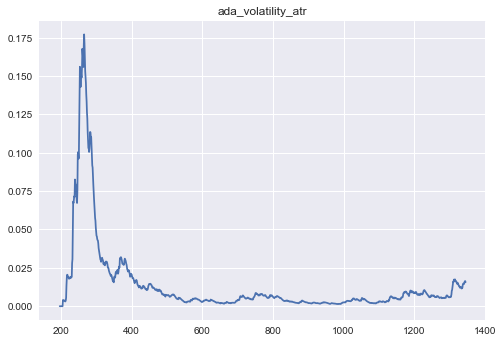

In [21]:
# All the features

for col in df_ta_ada.columns:
    plt.plot(df_ta_ada[col])
    plt.title(col)
    plt.show()

### For AXS

In [22]:
# Load data
df_axs = df_axs[~(df_axs['Date'] > '2020-12-31')]

# Clean nan values
df_axs = ta.utils.dropna(df_axs)

print(df_axs.columns)

# Add all ta features filling nans values
df_axs = ta.add_all_ta_features(
    df_axs, "open", "high", "low", "close", "volume", fillna=True
)

print(df_axs.columns)
print(len(df_axs.columns))

Index(['Date', 'close', 'high', 'low', 'open', 'volume'], dtype='object')
Index(['Date', 'close', 'high', 'low', 'open', 'volume', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em',
       'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbp', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
       'volatility_kcp', 'volatility_kchi', 'volatility_kcli',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
   

In [23]:
df_ta_axs=df_axs[['Date','volume_obv','momentum_rsi','trend_macd','volatility_atr']].copy()

In [24]:
df_ta_axs.columns = ['Date', 'axs_volume_obv','axs_momentum_rsi','axs_trend_macd','axs_volatility_atr']

In [25]:
df_axs.shape

(58, 92)

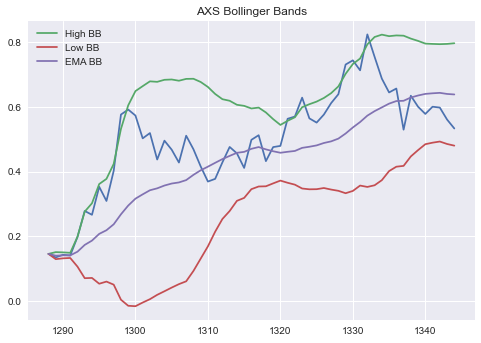

In [26]:
#Bollinger Bands

plt.plot(df_axs[0:57].close)
plt.plot(df_axs[0:57].volatility_bbh, label='High BB')
plt.plot(df_axs[0:57].volatility_bbl, label='Low BB')
plt.plot(df_axs[0:57].volatility_bbm, label='EMA BB')
plt.title('AXS Bollinger Bands')
plt.legend()
plt.show()

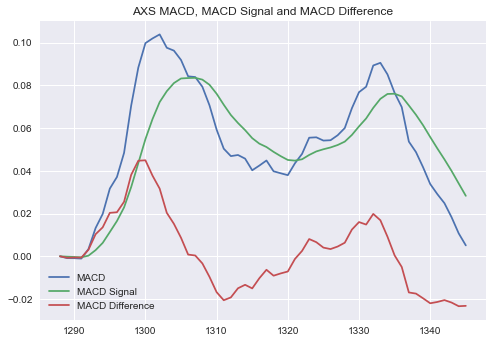

In [27]:
# MACD

plt.plot(df_axs[0:1148].trend_macd, label='MACD')
plt.plot(df_axs[0:1148].trend_macd_signal, label='MACD Signal')
plt.plot(df_axs[0:1148].trend_macd_diff, label='MACD Difference')
plt.title('AXS MACD, MACD Signal and MACD Difference')
plt.legend()
plt.show()

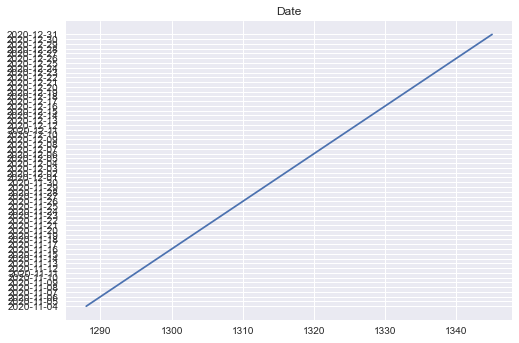

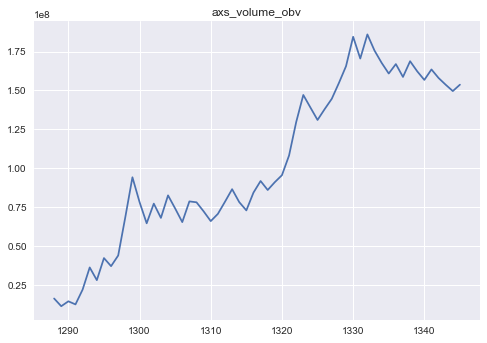

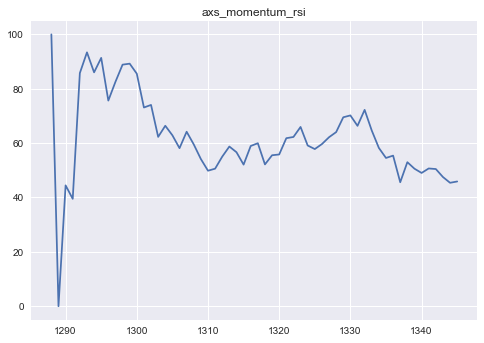

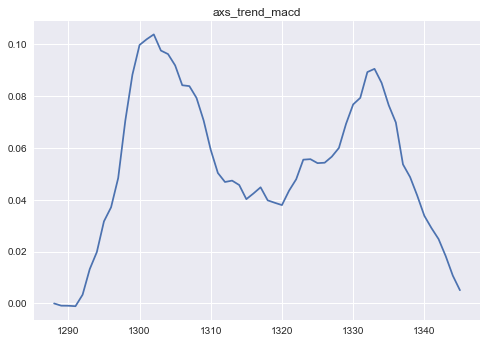

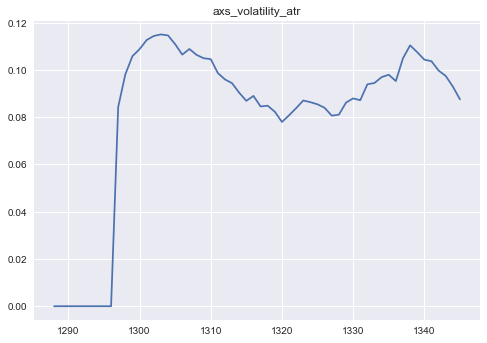

In [28]:
# All the features

for col in df_ta_axs.columns:
    plt.plot(df_ta_axs[col])
    plt.title(col)
    plt.show()

### For AVAX

In [29]:
# Load data
df_avax = df_avax[~(df_avax['Date'] > '2020-12-31')]

# Clean nan values
df_avax = ta.utils.dropna(df_avax)

print(df_avax.columns)

# Add all ta features filling nans values
df_avax = ta.add_all_ta_features(
    df_avax, "open", "high", "low", "close", "volume", fillna=True
)

print(df_avax.columns)
print(len(df_avax.columns))

Index(['Date', 'close', 'high', 'low', 'open', 'volume'], dtype='object')
Index(['Date', 'close', 'high', 'low', 'open', 'volume', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em',
       'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbp', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
       'volatility_kcp', 'volatility_kchi', 'volatility_kcli',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
   

In [30]:
df_ta_avax=df_avax[['Date','volume_obv','momentum_rsi','trend_macd','volatility_atr']].copy()

In [31]:
df_ta_avax.columns = ['Date', 'avax_volume_obv','avax_momentum_rsi','avax_trend_macd','avax_volatility_atr']

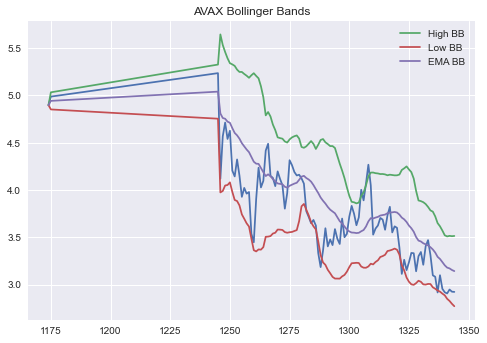

In [32]:
#Bollinger Bands

plt.plot(df_avax[0:102].close)
plt.plot(df_avax[0:102].volatility_bbh, label='High BB')
plt.plot(df_avax[0:102].volatility_bbl, label='Low BB')
plt.plot(df_avax[0:102].volatility_bbm, label='EMA BB')
plt.title('AVAX Bollinger Bands')
plt.legend()
plt.show()

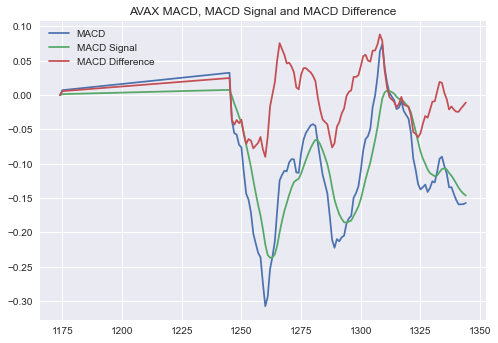

In [33]:
# MACD

plt.plot(df_avax[0:102].trend_macd, label='MACD')
plt.plot(df_avax[0:102].trend_macd_signal, label='MACD Signal')
plt.plot(df_avax[0:102].trend_macd_diff, label='MACD Difference')
plt.title('AVAX MACD, MACD Signal and MACD Difference')
plt.legend()
plt.show()

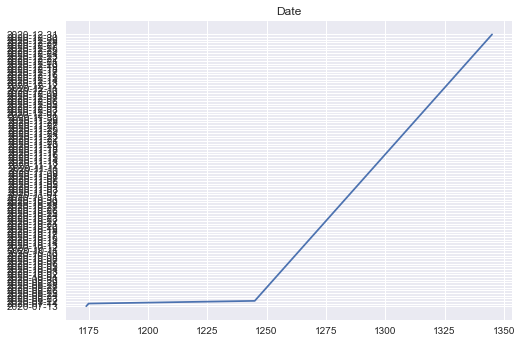

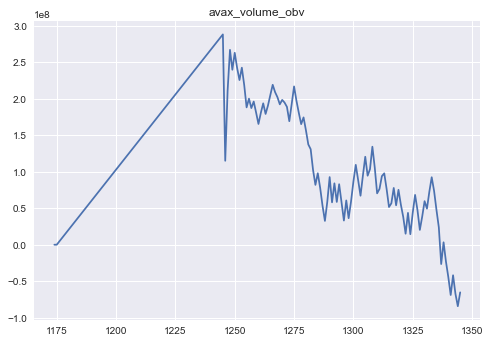

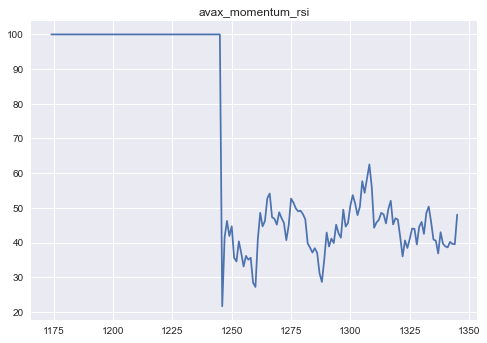

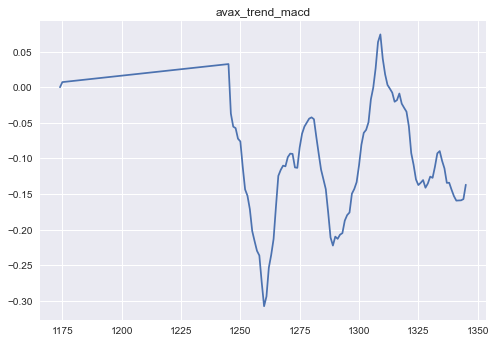

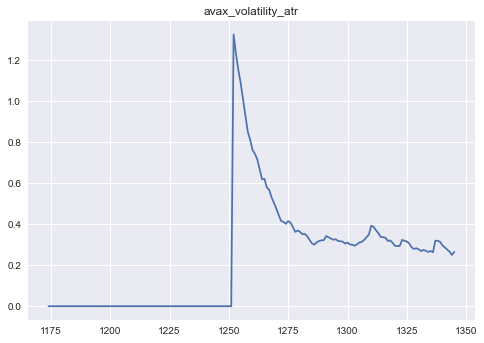

In [34]:
# All the features

for col in df_ta_avax.columns:
    plt.plot(df_ta_avax[col])
    plt.title(col)
    plt.show()

### For ATOM

In [35]:
# Load data
df_atom = df_atom[~(df_atom['Date'] > '2020-12-31')]

# Clean nan values
df_atom = ta.utils.dropna(df_atom)

print(df_atom.columns)

# Add all ta features filling nans values
df_atom = ta.add_all_ta_features(
    df_atom, "open", "high", "low", "close", "volume", fillna=True
)

print(df_atom.columns)
print(len(df_atom.columns))

Index(['Date', 'close', 'high', 'low', 'open', 'volume'], dtype='object')
Index(['Date', 'close', 'high', 'low', 'open', 'volume', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em',
       'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbp', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
       'volatility_kcp', 'volatility_kchi', 'volatility_kcli',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
   

In [36]:
df_ta_atom=df_atom[['Date','volume_obv','momentum_rsi','trend_macd','volatility_atr']].copy()

In [37]:
df_ta_atom.columns = ['Date', 'atom_volume_obv','atom_momentum_rsi','atom_trend_macd','atom_volatility_atr']

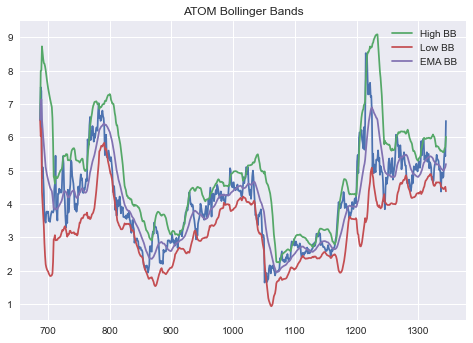

In [38]:
#Bollinger Bands

plt.plot(df_atom[0:1148].close)
plt.plot(df_atom[0:1148].volatility_bbh, label='High BB')
plt.plot(df_atom[0:1148].volatility_bbl, label='Low BB')
plt.plot(df_atom[0:1148].volatility_bbm, label='EMA BB')
plt.title('ATOM Bollinger Bands')
plt.legend()
plt.show()

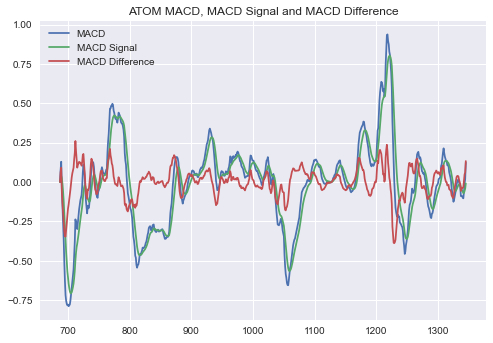

In [39]:
# MACD

plt.plot(df_atom[0:1148].trend_macd, label='MACD')
plt.plot(df_atom[0:1148].trend_macd_signal, label='MACD Signal')
plt.plot(df_atom[0:1148].trend_macd_diff, label='MACD Difference')
plt.title('ATOM MACD, MACD Signal and MACD Difference')
plt.legend()
plt.show()

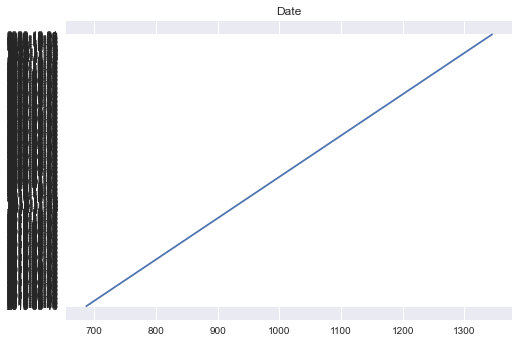

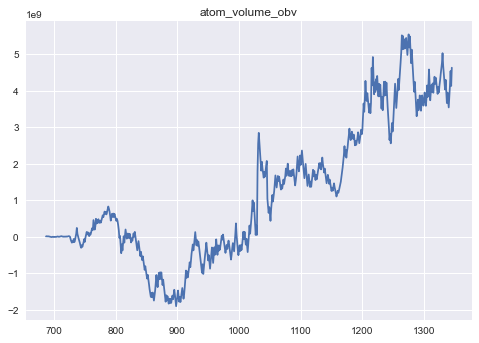

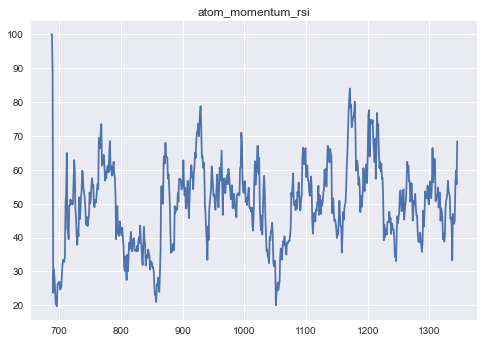

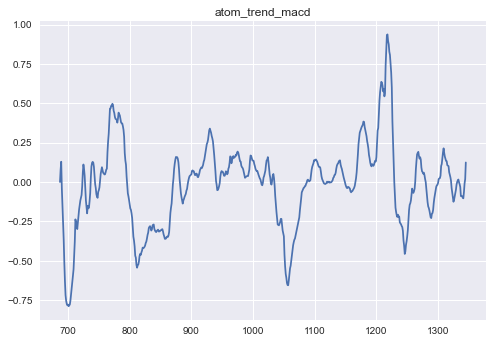

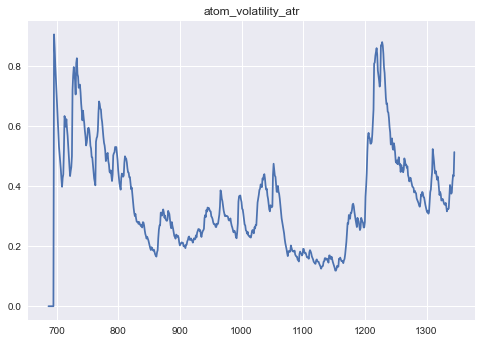

In [40]:
# All the features

for col in df_ta_atom.columns:
    plt.plot(df_ta_atom[col])
    plt.title(col)
    plt.show()

### For BTC

In [41]:
# Load data
df_btc = df_btc[~(df_btc['Date'] > '2020-12-31')]

# Clean nan values
df_btc = ta.utils.dropna(df_btc)

print(df_btc.columns)

# Add all ta features filling nans values
df_btc = ta.add_all_ta_features(
    df_btc, "open", "high", "low", "close", "volume", fillna=True
)

print(df_btc.columns)
print(len(df_btc.columns))

Index(['Date', 'close', 'high', 'low', 'open', 'volume'], dtype='object')
Index(['Date', 'close', 'high', 'low', 'open', 'volume', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em',
       'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbp', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
       'volatility_kcp', 'volatility_kchi', 'volatility_kcli',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
   

In [42]:
df_ta_btc=df_btc[['Date','volume_obv','momentum_rsi','trend_macd','volatility_atr']].copy()

In [43]:
df_ta_btc.columns = ['Date', 'btc_volume_obv','btc_momentum_rsi','btc_trend_macd','btc_volatility_atr']

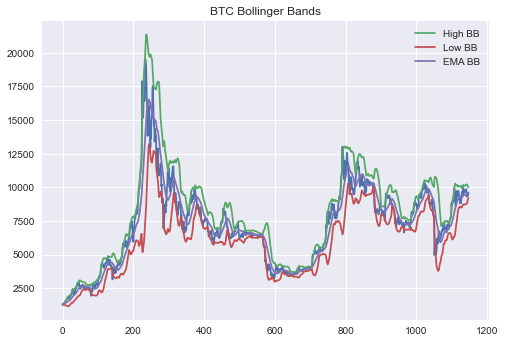

In [44]:
#Bollinger Bands

plt.plot(df_btc[0:1148].close)
plt.plot(df_btc[0:1148].volatility_bbh, label='High BB')
plt.plot(df_btc[0:1148].volatility_bbl, label='Low BB')
plt.plot(df_btc[0:1148].volatility_bbm, label='EMA BB')
plt.title('BTC Bollinger Bands')
plt.legend()
plt.show()


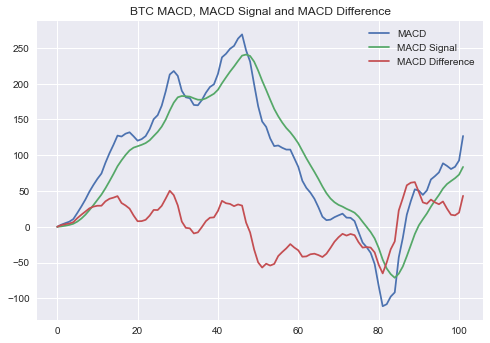

In [45]:
# MACD

plt.plot(df_btc[0:102].trend_macd, label='MACD')
plt.plot(df_btc[0:102].trend_macd_signal, label='MACD Signal')
plt.plot(df_btc[0:102].trend_macd_diff, label='MACD Difference')
plt.title('BTC MACD, MACD Signal and MACD Difference')
plt.legend()
plt.show()


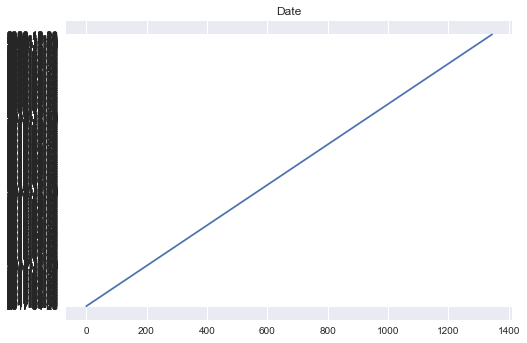

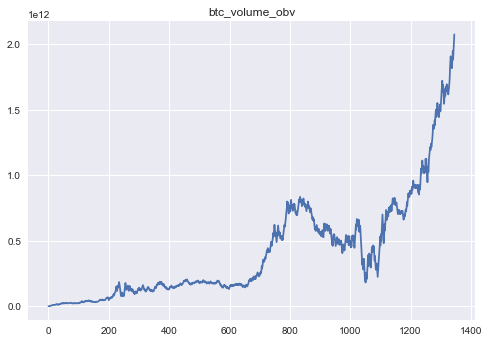

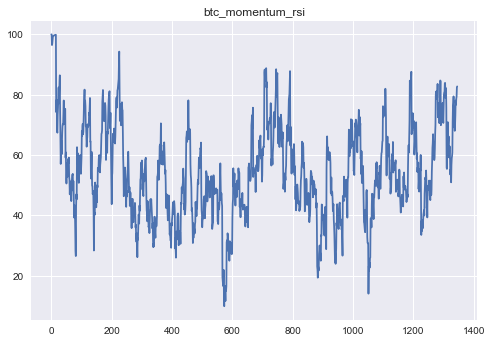

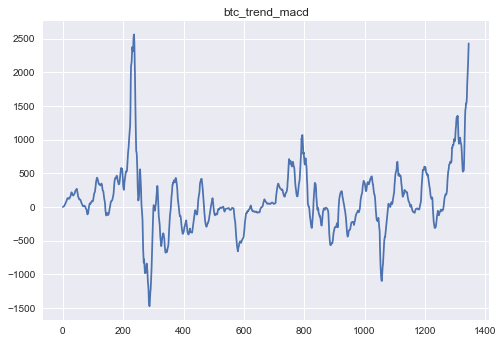

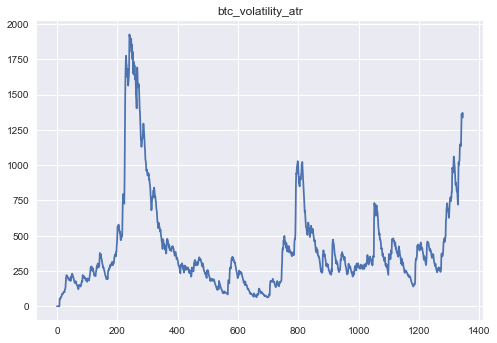

In [46]:
# All the features

for col in df_ta_btc.columns:
    plt.plot(df_ta_btc[col])
    plt.title(col)
    plt.show()


### For ETH

In [47]:
# Load data
df_eth = df_eth[~(df_eth['Date'] > '2020-12-31')]

# Clean nan values
df_eth = ta.utils.dropna(df_eth)

print(df_eth.columns)

# Add all ta features filling nans values
df_eth = ta.add_all_ta_features(
    df_eth, "open", "high", "low", "close", "volume", fillna=True
)

print(df_eth.columns)
print(len(df_eth.columns))

Index(['Date', 'close', 'high', 'low', 'open', 'volume'], dtype='object')
Index(['Date', 'close', 'high', 'low', 'open', 'volume', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em',
       'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbp', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
       'volatility_kcp', 'volatility_kchi', 'volatility_kcli',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
   

In [48]:
df_ta_eth=df_eth[['Date','volume_obv','momentum_rsi','trend_macd','volatility_atr']].copy()

In [49]:
df_ta_eth.columns = ['Date', 'eth_volume_obv','eth_momentum_rsi','eth_trend_macd','eth_volatility_atr']

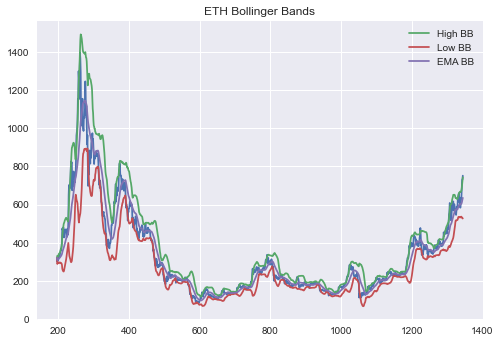

In [50]:
#Bollinger Bands

plt.plot(df_eth[0:1148].close)
plt.plot(df_eth[0:1148].volatility_bbh, label='High BB')
plt.plot(df_eth[0:1148].volatility_bbl, label='Low BB')
plt.plot(df_eth[0:1148].volatility_bbm, label='EMA BB')
plt.title('ETH Bollinger Bands')
plt.legend()
plt.show()


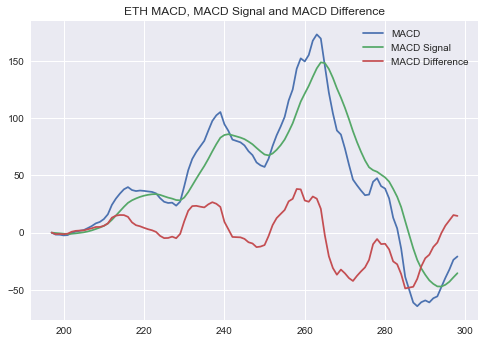

In [51]:
# MACD

plt.plot(df_eth[0:102].trend_macd, label='MACD')
plt.plot(df_eth[0:102].trend_macd_signal, label='MACD Signal')
plt.plot(df_eth[0:102].trend_macd_diff, label='MACD Difference')
plt.title('ETH MACD, MACD Signal and MACD Difference')
plt.legend()
plt.show()


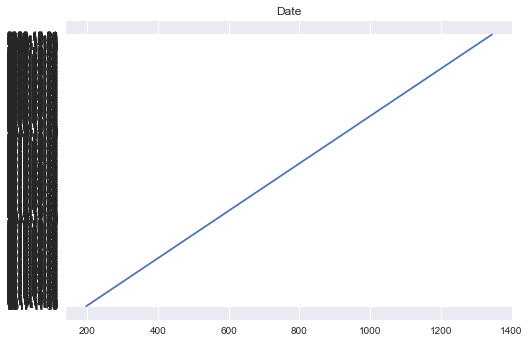

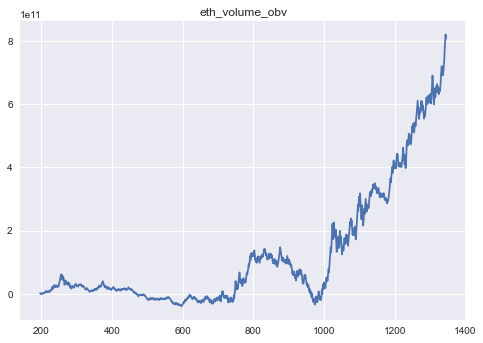

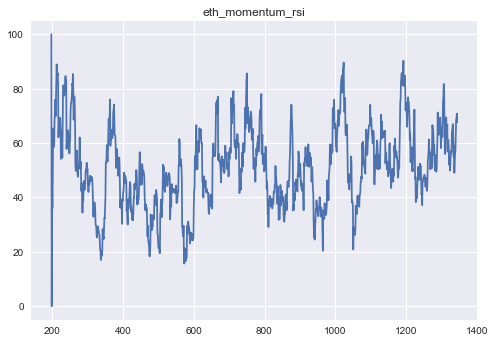

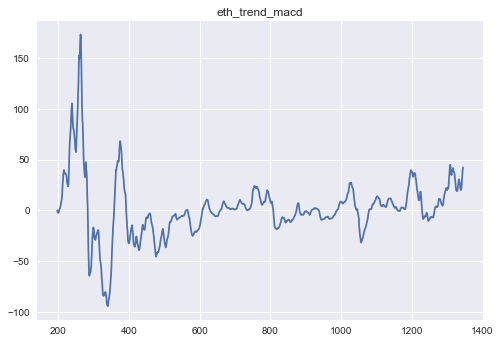

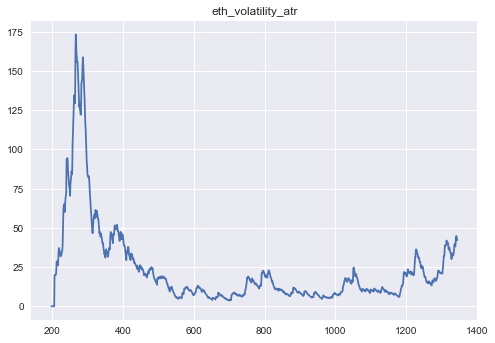

In [52]:
for col in df_ta_eth.columns:
    plt.plot(df_ta_eth[col])
    plt.title(col)
    plt.show()


### For LINK

In [53]:
# Load data
df_link = df_link[~(df_link['Date'] > '2020-12-31')]

# Clean nan values
df_link = ta.utils.dropna(df_link)

print(df_link.columns)

# Add all ta features filling nans values
df_link = ta.add_all_ta_features(
    df_link, "open", "high", "low", "close", "volume", fillna=True
)

print(df_link.columns)
print(len(df_link.columns))

Index(['Date', 'close', 'high', 'low', 'open', 'volume'], dtype='object')
Index(['Date', 'close', 'high', 'low', 'open', 'volume', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em',
       'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbp', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
       'volatility_kcp', 'volatility_kchi', 'volatility_kcli',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
   

In [54]:
df_ta_link=df_link[['Date','volume_obv','momentum_rsi','trend_macd','volatility_atr']].copy()

In [55]:
df_ta_link.columns = ['Date', 'link_volume_obv','link_momentum_rsi','link_trend_macd','link_volatility_atr']

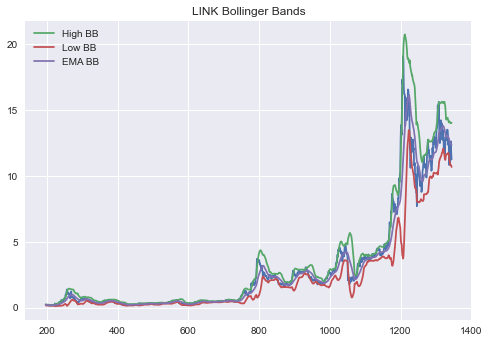

In [56]:
#Bollinger Bands

plt.plot(df_link[0:1148].close)
plt.plot(df_link[0:1148].volatility_bbh, label='High BB')
plt.plot(df_link[0:1148].volatility_bbl, label='Low BB')
plt.plot(df_link[0:1148].volatility_bbm, label='EMA BB')
plt.title('LINK Bollinger Bands')
plt.legend()
plt.show()


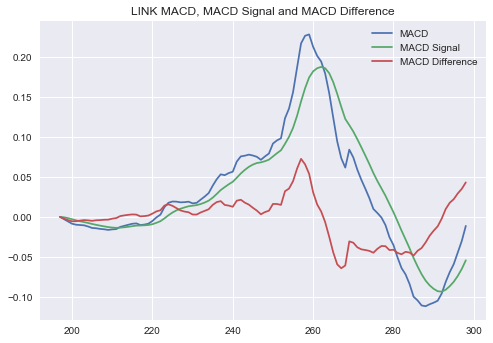

In [57]:
# MACD

plt.plot(df_link[0:102].trend_macd, label='MACD')
plt.plot(df_link[0:102].trend_macd_signal, label='MACD Signal')
plt.plot(df_link[0:102].trend_macd_diff, label='MACD Difference')
plt.title('LINK MACD, MACD Signal and MACD Difference')
plt.legend()
plt.show()


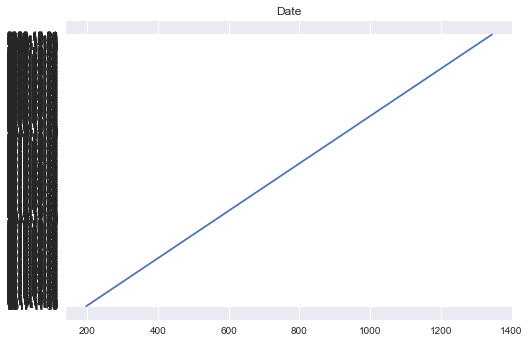

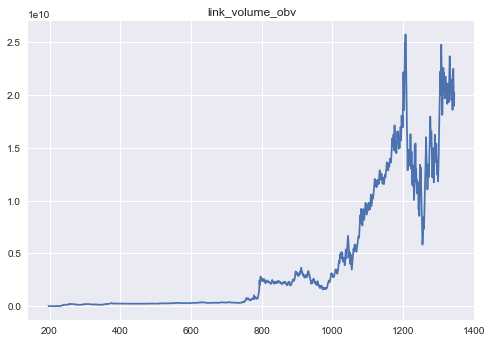

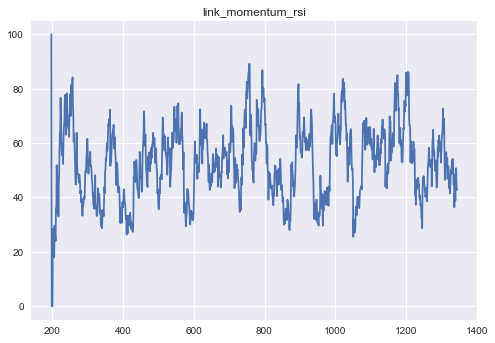

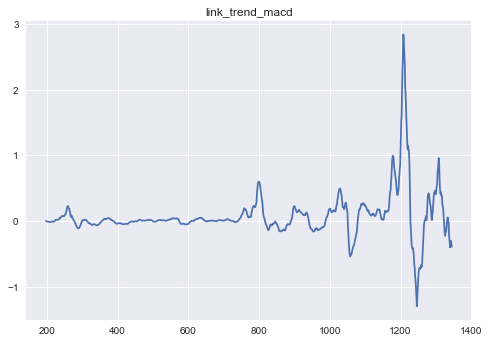

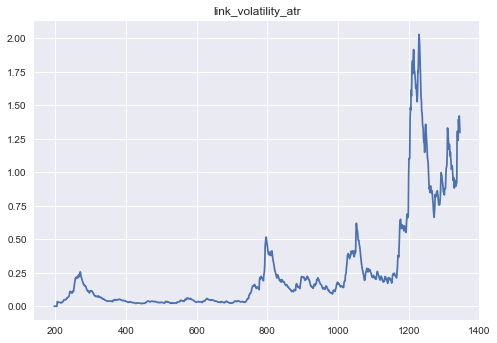

In [58]:
# All the features

for col in df_ta_link.columns:
    plt.plot(df_ta_link[col])
    plt.title(col)
    plt.show()


### For LUNA1

In [59]:
# Load data
df_luna1 = df_luna1[~(df_luna1['Date'] > '2020-12-31')]

# Clean nan values
df_luna1 = ta.utils.dropna(df_luna1)

print(df_luna1.columns)

# Add all ta features filling nans values
df_luna1 = ta.add_all_ta_features(
    df_luna1, "open", "high", "low", "close", "volume", fillna=True
)

print(df_luna1.columns)
print(len(df_luna1.columns))

Index(['Date', 'close', 'high', 'low', 'open', 'volume'], dtype='object')
Index(['Date', 'close', 'high', 'low', 'open', 'volume', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em',
       'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbp', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
       'volatility_kcp', 'volatility_kchi', 'volatility_kcli',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
   

In [60]:
df_ta_luna1=df_luna1[['Date','volume_obv','momentum_rsi','trend_macd','volatility_atr']].copy()

In [61]:
df_ta_luna1.columns = ['Date', 'luna1_volume_obv','luna1_momentum_rsi','luna1_trend_macd','luna1_volatility_atr']

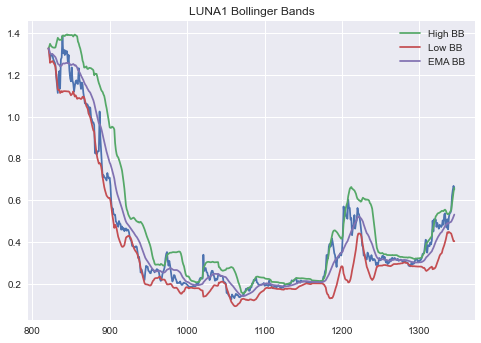

In [62]:
plt.plot(df_luna1[0:1148].close)
plt.plot(df_luna1[0:1148].volatility_bbh, label='High BB')
plt.plot(df_luna1[0:1148].volatility_bbl, label='Low BB')
plt.plot(df_luna1[0:1148].volatility_bbm, label='EMA BB')
plt.title('LUNA1 Bollinger Bands')
plt.legend()
plt.show()


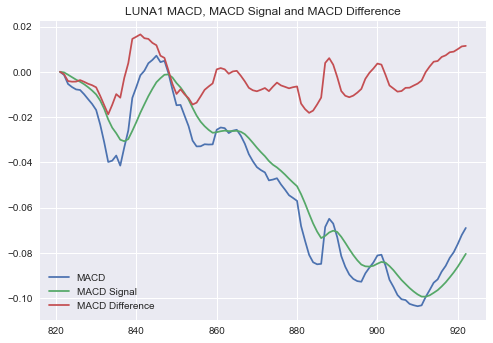

In [63]:
plt.plot(df_luna1[0:102].trend_macd, label='MACD')
plt.plot(df_luna1[0:102].trend_macd_signal, label='MACD Signal')
plt.plot(df_luna1[0:102].trend_macd_diff, label='MACD Difference')
plt.title('LUNA1 MACD, MACD Signal and MACD Difference')
plt.legend()
plt.show()


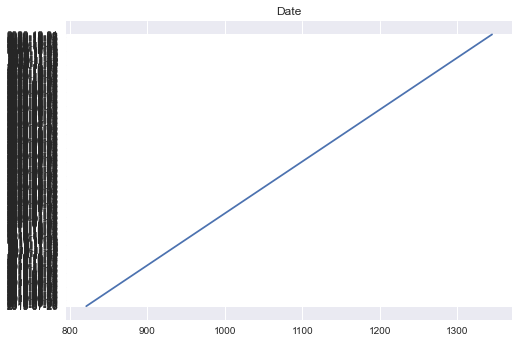

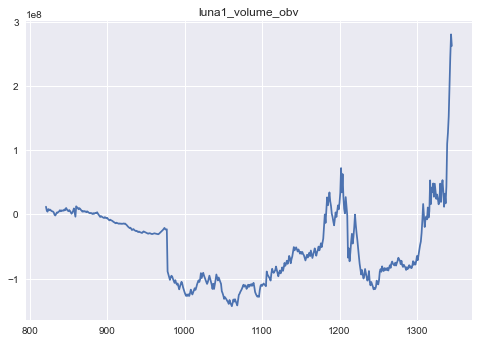

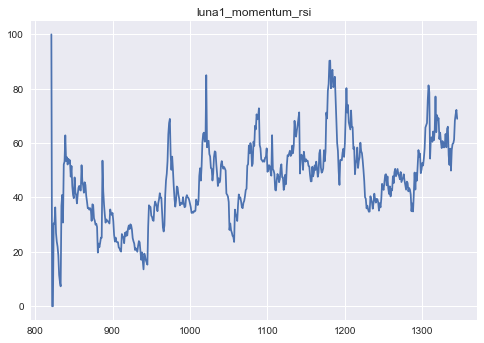

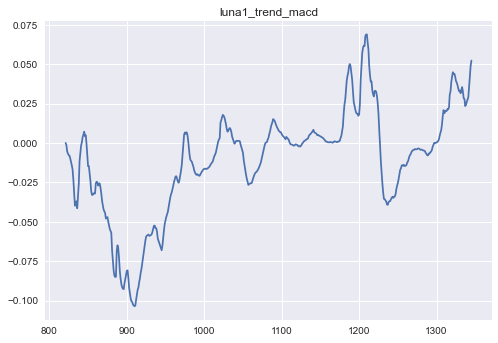

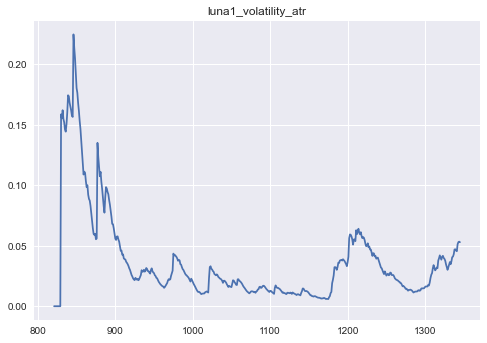

In [64]:
# All the features

for col in df_ta_luna1.columns:
    plt.plot(df_ta_luna1[col])
    plt.title(col)
    plt.show()


### For MATIC

In [65]:
# Load data
df_matic = df_matic[~(df_matic['Date'] > '2020-12-31')]

# Clean nan values
df_matic = ta.utils.dropna(df_matic)

print(df_matic.columns)

# Add all ta features filling nans values
df_matic = ta.add_all_ta_features(
    df_matic, "open", "high", "low", "close", "volume", fillna=True
)

print(df_matic.columns)
print(len(df_matic.columns))

Index(['Date', 'close', 'high', 'low', 'open', 'volume'], dtype='object')
Index(['Date', 'close', 'high', 'low', 'open', 'volume', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em',
       'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbp', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
       'volatility_kcp', 'volatility_kchi', 'volatility_kcli',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
   

In [66]:
df_ta_matic=df_matic[['Date','volume_obv','momentum_rsi','trend_macd','volatility_atr']].copy()

In [67]:
df_ta_matic.columns = ['Date', 'matic_volume_obv','matic_momentum_rsi','matic_trend_macd','matic_volatility_atr']

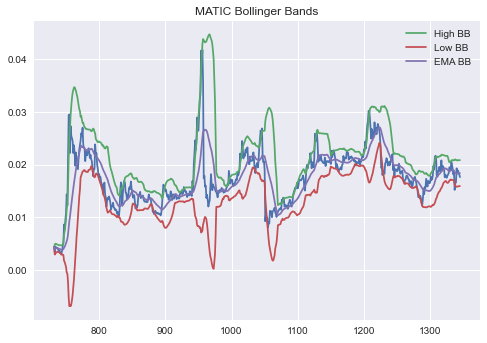

In [68]:
#Bollinger Bands

plt.plot(df_matic[0:1148].close)
plt.plot(df_matic[0:1148].volatility_bbh, label='High BB')
plt.plot(df_matic[0:1148].volatility_bbl, label='Low BB')
plt.plot(df_matic[0:1148].volatility_bbm, label='EMA BB')
plt.title('MATIC Bollinger Bands')
plt.legend()
plt.show()


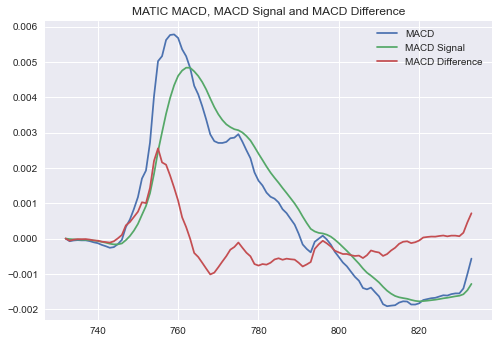

In [69]:
# MACD

plt.plot(df_matic[0:102].trend_macd, label='MACD')
plt.plot(df_matic[0:102].trend_macd_signal, label='MACD Signal')
plt.plot(df_matic[0:102].trend_macd_diff, label='MACD Difference')
plt.title('MATIC MACD, MACD Signal and MACD Difference')
plt.legend()
plt.show()


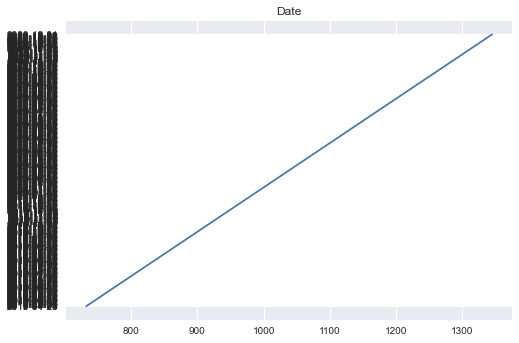

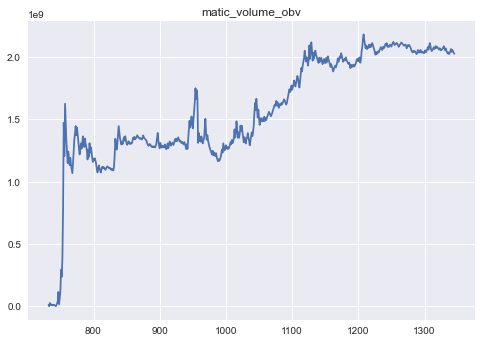

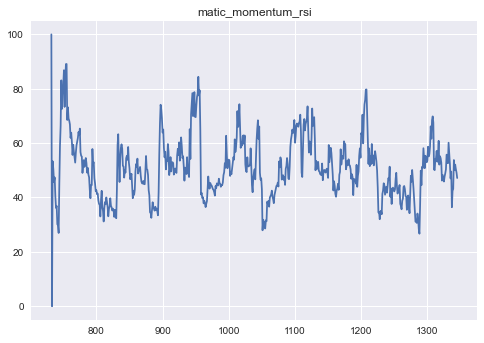

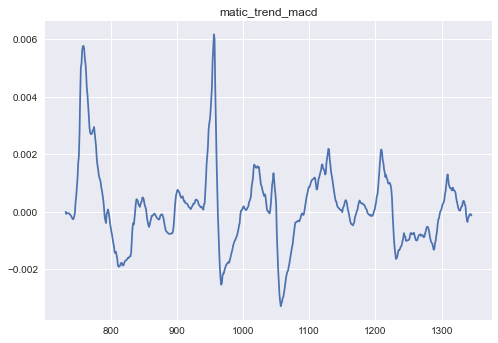

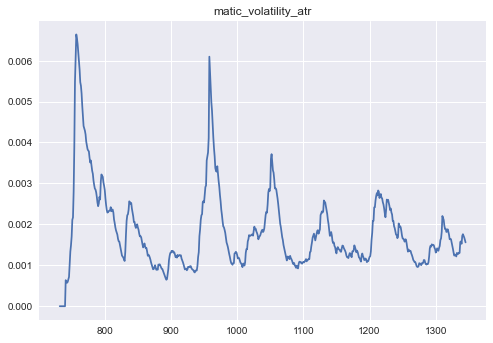

In [70]:
# All the features

for col in df_ta_matic.columns:
    plt.plot(df_ta_matic[col])
    plt.title(col)
    plt.show()


### For SOL

In [71]:
# Load data
df_sol = df_sol[~(df_sol['Date'] > '2020-12-31')]

# Clean nan values
df_sol = ta.utils.dropna(df_sol)

print(df_sol.columns)

# Add all ta features filling nans values
df_sol = ta.add_all_ta_features(
    df_sol, "open", "high", "low", "close", "volume", fillna=True
)

print(df_sol.columns)
print(len(df_sol.columns))

Index(['Date', 'close', 'high', 'low', 'open', 'volume'], dtype='object')
Index(['Date', 'close', 'high', 'low', 'open', 'volume', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em',
       'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbp', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
       'volatility_kcp', 'volatility_kchi', 'volatility_kcli',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
   

In [72]:
df_ta_sol=df_sol[['Date','volume_obv','momentum_rsi','trend_macd','volatility_atr']].copy()

In [73]:
df_ta_sol.columns = ['Date', 'sol_volume_obv','sol_momentum_rsi','sol_trend_macd','sol_volatility_atr']

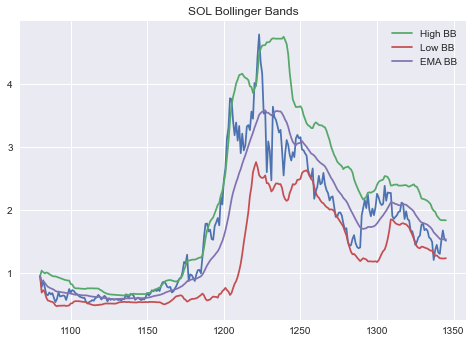

In [74]:
plt.plot(df_sol[0:1148].close)
plt.plot(df_sol[0:1148].volatility_bbh, label='High BB')
plt.plot(df_sol[0:1148].volatility_bbl, label='Low BB')
plt.plot(df_sol[0:1148].volatility_bbm, label='EMA BB')
plt.title('SOL Bollinger Bands')
plt.legend()
plt.show()


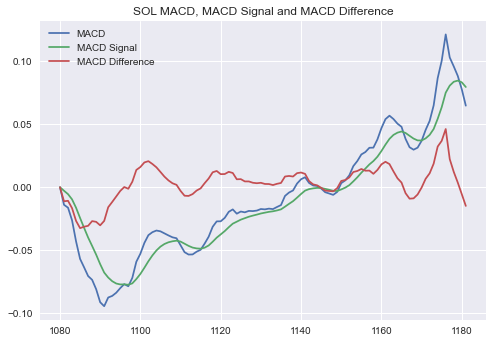

In [75]:
# MACD

plt.plot(df_sol[0:102].trend_macd, label='MACD')
plt.plot(df_sol[0:102].trend_macd_signal, label='MACD Signal')
plt.plot(df_sol[0:102].trend_macd_diff, label='MACD Difference')
plt.title('SOL MACD, MACD Signal and MACD Difference')
plt.legend()
plt.show()


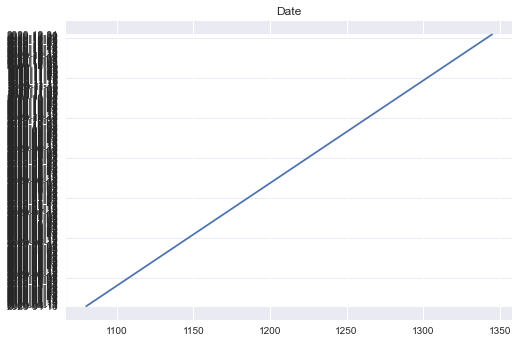

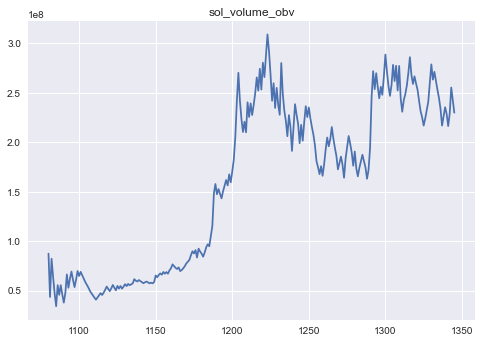

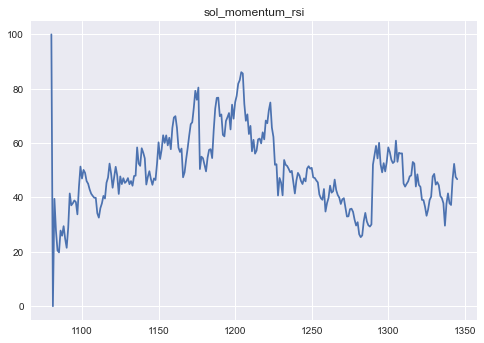

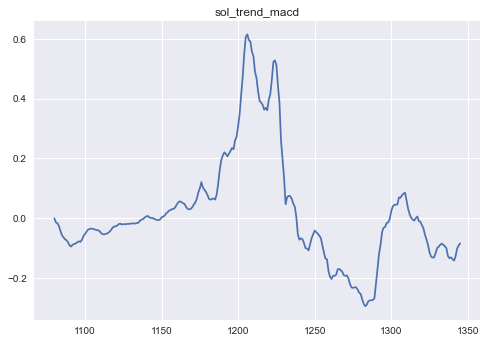

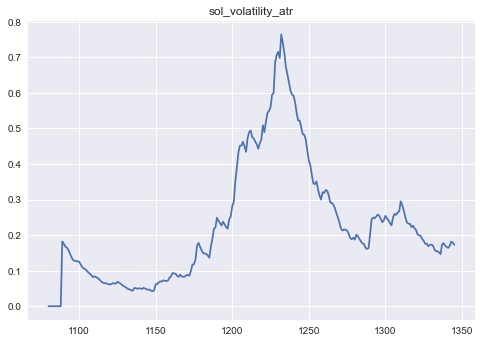

In [76]:
# All the features

for col in df_ta_sol.columns:
    plt.plot(df_ta_sol[col])
    plt.title(col)
    plt.show()


### Exporting for Use in Models

In [77]:
df_coins_talist = [df_ta_ada, df_ta_atom, df_ta_avax, df_ta_axs, df_ta_btc, df_ta_eth, df_ta_link, df_ta_luna1, df_ta_matic, df_ta_sol]

In [78]:
df_ta_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='left'), df_coins_talist)

In [79]:
df_ta_merged.head()

,Date,ada_volume_obv,ada_momentum_rsi,ada_trend_macd,ada_volatility_atr,atom_volume_obv,atom_momentum_rsi,atom_trend_macd,atom_volatility_atr,avax_volume_obv,...,luna1_trend_macd,luna1_volatility_atr,matic_volume_obv,matic_momentum_rsi,matic_trend_macd,matic_volatility_atr,sol_volume_obv,sol_momentum_rsi,sol_trend_macd,sol_volatility_atr
0,2017-11-09,18716200.0,100.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-11-10,11949420.0,0.000000,-0.000394,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-11-11,17481640.0,6.490363,-0.000672,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-11-12,10201390.0,3.686647,-0.001159,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-11-13,14620830.0,22.713445,-0.001381,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
df_ta_merged.to_csv("ta_merged_data.csv", index=False)